In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, make_scorer
import category_encoders as ce
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve
)
from sklearn.model_selection import StratifiedShuffleSplit
from pathlib import Path
import json

In [2]:
# read data
X_train = pd.read_csv('data/X_train.csv')
X_val   = pd.read_csv('data/X_val.csv')
X_test  = pd.read_csv('data/X_test.csv')

y_train = pd.read_csv('data/y_train.csv')
y_val   = pd.read_csv('data/y_val.csv')
y_test  = pd.read_csv('data/y_test.csv')

# check data
print("Shapes:")
print("  X_train:", X_train.shape, " y_train:", y_train.shape)
print("  X_val  :", X_val.shape,   " y_val  :", y_val.shape)
print("  X_test :", X_test.shape,  " y_test :", y_test.shape)


y_train = y_train.astype(int)
y_val   = y_val.astype(int)
y_test  = y_test.astype(int)



Shapes:
  X_train: (766956, 74)  y_train: (766956, 1)
  X_val  : (328696, 74)  y_val  : (328696, 1)
  X_test : (273914, 74)  y_test : (273914, 1)


In [3]:
# 1 encoding

# check object columns in the training set
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", categorical_cols)
# Display the first five rows of the application features
print("First five rows of application features:")
print(X_train.loc[:, categorical_cols].head())

# calculate the number of categories in each categorical column
num_categories = X_train[categorical_cols].nunique()
print("Number of categories in each categorical column:")
print(num_categories)
# original categorical columns
# term: "36 months" -> 36，"60 months" -> 60
X_train['term'] = X_train['term'].str.extract('(\d+)').astype(float)
X_val['term'] = X_val['term'].str.extract('(\d+)').astype(float)
X_test['term'] = X_test['term'].str.extract('(\d+)').astype(float)

# grade: transfer to integer
def convert_grade(x):
    if pd.isnull(x):
        return np.nan
    return ord(x) - ord('A') + 1  # A -> 1, B -> 2, ..., G -> 7
X_train['grade'] = X_train['grade'].apply(convert_grade)
X_val['grade'] = X_val['grade'].apply(convert_grade)
X_test['grade'] = X_test['grade'].apply(convert_grade)

# sub_grade: transfer to integer
def convert_sub_grade(x):
    if pd.isnull(x):
        return np.nan
    return ord(x[0]) - (ord('A') + 1)* 10 + (ord(x[1]) - ord('1'))   # A1 -> 11, B2 -> 22, ..., G5 -> 75

X_train['sub_grade'] = X_train['sub_grade'].apply(convert_sub_grade)
X_val['sub_grade'] = X_val['sub_grade'].apply(convert_sub_grade)
X_test['sub_grade'] = X_test['sub_grade'].apply(convert_sub_grade)

# emp_length: transfer to integer（< 1 year -> 0, 10+ years -> 10）
def convert_emp_length(x):
    if pd.isnull(x):
        return np.nan
    if '<' in x:
        return 0
    if '10+' in x:
        return 10
    return int(x.strip().split()[0])

X_train['emp_length'] = X_train['emp_length'].apply(convert_emp_length)
X_val['emp_length'] = X_val['emp_length'].apply(convert_emp_length)
X_test['emp_length'] = X_test['emp_length'].apply(convert_emp_length)
# datatime columns dealing
def convert_datetime_to_numeric(df, datetime_col):
    df[datetime_col] = pd.to_datetime(df[datetime_col], errors='coerce')
    df[datetime_col + '_year'] = df[datetime_col].dt.year
    df[datetime_col + '_month'] = df[datetime_col].dt.month
    df = df.drop(columns=[datetime_col])
    return df

X_train = convert_datetime_to_numeric(X_train, 'earliest_cr_line')
X_train = convert_datetime_to_numeric(X_train, 'issue_d')
X_val = convert_datetime_to_numeric(X_val, 'earliest_cr_line')
X_val = convert_datetime_to_numeric(X_val, 'issue_d')
X_test = convert_datetime_to_numeric(X_test, 'earliest_cr_line')
X_test = convert_datetime_to_numeric(X_test, 'issue_d')
# one-hot encoding for categorical columns
col_list = ['home_ownership', 'verification_status', 'purpose']

# 1) Fill missing values with 'Missing'
X_train[col_list] = X_train[col_list].fillna('Missing')
X_val[col_list]   = X_val[col_list].fillna('Missing')
X_test[col_list]  = X_test[col_list].fillna('Missing')

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary')
ohe.fit(X_train[col_list])

def apply_ohe(df, cols, encoder):
    arr = encoder.transform(df[cols])
    feat_names = encoder.get_feature_names_out(cols)
    enc_df = pd.DataFrame(arr, columns=feat_names, index=df.index)
    return pd.concat([df.drop(columns=cols), enc_df], axis=1)

X_train = apply_ohe(X_train, col_list, ohe)
X_val   = apply_ohe(X_val,   col_list, ohe)
X_test  = apply_ohe(X_test,  col_list, ohe)

# target encoding

for df in (X_train, X_val, X_test):
    df['zip_code'] = df['zip_code'].str[:3].fillna('Missing').astype(str)

te_zip = ce.TargetEncoder(cols=['zip_code'], min_samples_leaf=50, smoothing=20)
te_zip.fit(X_train[['zip_code']], y_train)

for df in (X_train, X_val, X_test):
    df['zip_code'] = te_zip.transform(df[['zip_code']])['zip_code']

# addr_state =
te_state = ce.TargetEncoder(cols=['addr_state'], min_samples_leaf=50, smoothing=20)
te_state.fit(X_train[['addr_state']], y_train)
for df in (X_train, X_val, X_test):
    df['addr_state'] = te_state.transform(df[['addr_state']])['addr_state']
# binary columns coding

# initial_list_status : convert to integer (e.g., 'f' -> 0, 'w' -> 1)
def convert_initial_list_status(x):
    if x == 'f':
        return 0
    elif x == 'w':
        return 1

# application_type : convert to integer (e.g., 'Individual' -> 0, 'Joint App' -> 1)
def convert_application_type(x):
    if x == 'Individual':
        return 0
    elif x == 'Joint App':
        return 1


def convert_hardship_debt_flag(x):
    if x == 'N':
        return 0
    elif x == 'Y':
        return 1


def convert_disbursement_method(x):
    if x == 'Cash':
        return 0
    elif x == 'DirectPay':
        return 1



for df in (X_train, X_val, X_test):
    df['initial_list_status'] = df['initial_list_status'].apply(convert_initial_list_status)
    df['application_type'] = df['application_type'].apply(convert_application_type)
    df['hardship_flag'] = df['hardship_flag'].apply(convert_hardship_debt_flag)
    df['disbursement_method'] = df['disbursement_method'].apply(convert_disbursement_method)
    df['debt_settlement_flag'] = df['debt_settlement_flag'].apply(convert_hardship_debt_flag)

# check for NaN values in application features
print("Checking for NaN values in application features:")
print(X_train.isnull().sum().sort_values(ascending=False))
# impute missing values
# deal with missing values ,# using median for numerical columns
imputer = SimpleImputer(strategy='median')
for df in (X_train, X_val, X_test):
    # Fill missing values for categorical columns with 'Missing'
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    df[num_cols] = imputer.fit_transform(df[num_cols])

smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("SMOTE resampling results:")
print(y_train_resampled.value_counts())
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Categorical columns: ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'purpose', 'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'application_type', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag']
First five rows of application features:


<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:17: SyntaxWarning: invalid escape sequence '\d'
<>:18: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:17: SyntaxWarning: invalid escape sequence '\d'
<>:18: SyntaxWarning: invalid escape sequence '\d'
/var/folders/xg/6886p3rj5kb44k2smttjctf80000gn/T/ipykernel_5597/2361526693.py:16: SyntaxWarning: invalid escape sequence '\d'
  X_train['term'] = X_train['term'].str.extract('(\d+)').astype(float)
/var/folders/xg/6886p3rj5kb44k2smttjctf80000gn/T/ipykernel_5597/2361526693.py:17: SyntaxWarning: invalid escape sequence '\d'
  X_val['term'] = X_val['term'].str.extract('(\d+)').astype(float)
/var/folders/xg/6886p3rj5kb44k2smttjctf80000gn/T/ipykernel_5597/2361526693.py:18: SyntaxWarning: invalid escape sequence '\d'
  X_test['term'] = X_test['term'].str.extract('(\d+)').astype(float)


         term grade sub_grade emp_length home_ownership verification_status  \
0   36 months     B        B2  10+ years       MORTGAGE            Verified   
1   36 months     B        B3        NaN       MORTGAGE            Verified   
2   36 months     A        A5  10+ years            OWN        Not Verified   
3   36 months     B        B1    4 years       MORTGAGE        Not Verified   
4   36 months     D        D4   < 1 year           RENT            Verified   

    issue_d             purpose zip_code addr_state earliest_cr_line  \
0  Aug-2013  debt_consolidation    983xx         WA         Jan-1992   
1  Jan-2015  debt_consolidation    496xx         MI         Apr-2003   
2  Jul-2017         credit_card    296xx         SC         Jun-1998   
3  Oct-2016  debt_consolidation    809xx         CO         Oct-2012   
4  Oct-2013  debt_consolidation    100xx         NY         Dec-2003   

  initial_list_status application_type hardship_flag disbursement_method  \
0               

/var/folders/xg/6886p3rj5kb44k2smttjctf80000gn/T/ipykernel_5597/2361526693.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[datetime_col] = pd.to_datetime(df[datetime_col], errors='coerce')
/var/folders/xg/6886p3rj5kb44k2smttjctf80000gn/T/ipykernel_5597/2361526693.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[datetime_col] = pd.to_datetime(df[datetime_col], errors='coerce')
/var/folders/xg/6886p3rj5kb44k2smttjctf80000gn/T/ipykernel_5597/2361526693.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[datetime_col] = pd.to_datetime(df[datetime_col], errors

Checking for NaN values in application features:
il_util                 496507
all_util                454345
total_cu_tl             454315
inq_last_12m            454315
total_bal_il            454314
                         ...  
disbursement_method          0
debt_settlement_flag         0
issue_d_year                 0
issue_d_month                0
purpose_wedding              0
Length: 96, dtype: int64
SMOTE resampling results:
default
0          604093
1          604093
Name: count, dtype: int64


In [4]:
final_features = ['fico_range_low', 'debt_settlement_flag', 'term', 'grade', 'issue_d_year', 'num_sats', 'zip_code', 'acc_open_past_24mths', 'total_bc_limit', 'installment', 'mo_sin_old_rev_tl_op', 'num_rev_accts', 'dti', 'inq_last_6mths', 'sub_grade', 'num_rev_tl_bal_gt_0', 'avg_cur_bal', 'hardship_flag', 'mort_acc', 'delinq_2yrs', 'bc_open_to_buy', 'purpose_small_business', 'home_ownership_RENT', 'home_ownership_MORTGAGE', 'total_bal_ex_mort', 'num_bc_sats']
# rescale the final features after feature selection
# 1. select features
X_train_reduced = X_train[final_features]  
X_val_reduced   = X_val[final_features]
X_test_reduced  = X_test[final_features]

# 2. sample standardization
X_train_scaled = scaler.fit_transform(X_train_reduced)
X_val_scaled   = scaler.transform(X_val_reduced)
X_test_scaled  = scaler.transform(X_test_reduced)

# 3. add column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=final_features)
X_val_scaled_df   = pd.DataFrame(X_val_scaled, columns=final_features)
X_test_scaled_df  = pd.DataFrame(X_test_scaled, columns=final_features)


Run the model

In [5]:
# 第一步：train model
from xgboost import XGBClassifier
import shap

xgb_model = XGBClassifier(eval_metric='auc')
xgb_model.fit(X_train_scaled_df, y_train)

# shap analysis
explainer_xgb = shap.Explainer(xgb_model, X_train_scaled_df)
shap_values_xgb = explainer_xgb(X_test_scaled_df)



100%|===================| 273851/273914 [20:08<00:00]        

In [6]:
def load_best_params(out_dir="results"):
    """
    read the best parameters from result files in the specified directory.
    """
    result_files = Path(out_dir).glob("*_result.json")
    param_dict = {}
    for file in result_files:
        with open(file, "r", encoding="utf-8") as f:
            res = json.load(f)
            model_name = res["model"]
            param_dict[model_name] = res.get("best_params", {})
    return param_dict


best_param_map = load_best_params("results")

In [7]:
best_param_map

{'Random Forest': {'class_weight': None,
  'max_depth': 8,
  'max_features': 'sqrt',
  'min_samples_leaf': 20,
  'n_estimators': 100},
 'SVM': {'C': 0.5, 'class_weight': 'balanced', 'gamma': 'scale'},
 'Decision Tree': {'class_weight': None,
  'max_depth': 8,
  'min_samples_leaf': 1},
 'Neural Network': {'alpha': 0.0001,
  'hidden_layer_sizes': [128],
  'learning_rate_init': 0.001},
 'Logistic Regression': {'C': 0.5, 'class_weight': 'balanced'},
 'XGBoost': {'colsample_bytree': 1.0,
  'learning_rate': 0.05,
  'max_depth': 3,
  'n_estimators': 500,
  'subsample': 0.8}}

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:17:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:17:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:17:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:17:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

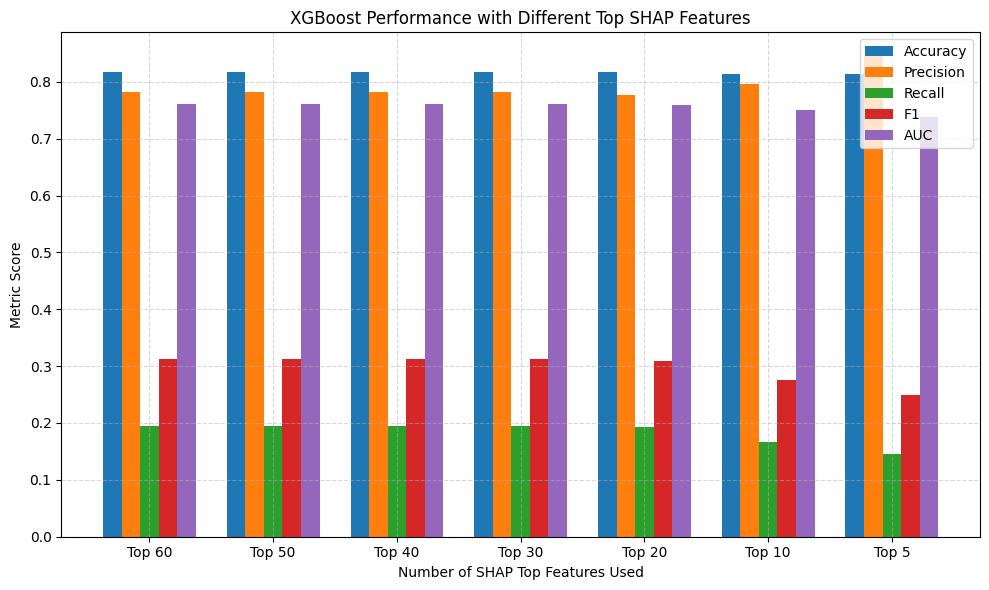

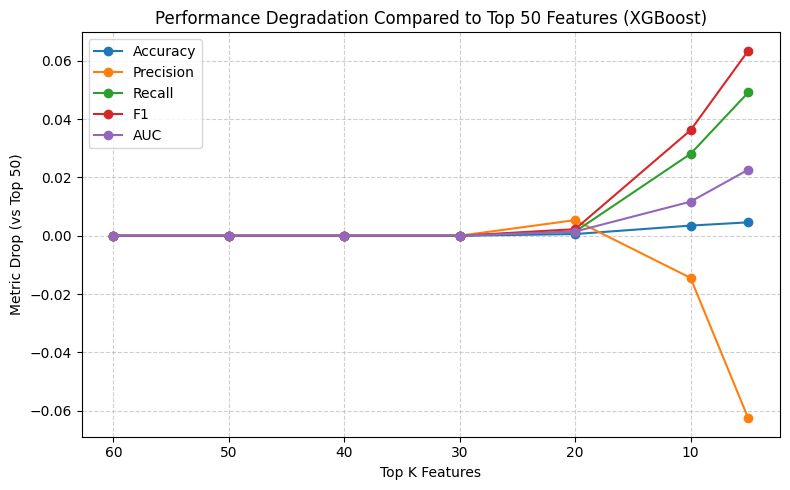

In [8]:
def evaluate_model_with_top_features(model_name, top_k, shap_values, X_train_df, X_train_scaled, X_test_scaled, y_train, y_test, best_param_map):
    """
    use SHAP values to select top-k features and evaluate the model.
    """
    # select important features based on SHAP values
    shap_array = np.abs(shap_values.values).mean(axis=0)
    feature_importance = pd.Series(shap_array, index=X_train_df.columns).sort_values(ascending=False)
    selected_features = feature_importance.head(top_k).index.tolist()

    
    X_train_topk = X_train_df[selected_features]
    X_test_topk  = X_train_df[selected_features].copy()
    idxs = [X_train_df.columns.get_loc(col) for col in selected_features]
    X_train_topk = X_train_scaled[:, idxs]
    X_test_topk  = X_test_scaled[:, idxs]

    # model initialization
    if model_name == "LogisticRegression":
        model = LogisticRegression(**best_param_map.get(model_name, {}), random_state=42)
    elif model_name == "Decision Tree":
        model = DecisionTreeClassifier(**best_param_map.get(model_name, {}), random_state=42)
    elif model_name == "Neural Network":
        model = MLPClassifier(**best_param_map.get(model_name, {}), random_state=42)
    elif model_name == "XGBoost":
        model = XGBClassifier(**best_param_map.get(model_name, {}), use_label_encoder=False, eval_metric='logloss', random_state=42)
    else:
        raise ValueError(f"Unknown model: {model_name}")

    # train and evaluate the model
    model.fit(X_train_topk, y_train)
    y_pred = model.predict(X_test_topk)
    y_prob = model.predict_proba(X_test_topk)[:, 1] if hasattr(model, "predict_proba") else y_pred

    return{
        'Top': top_k,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_prob)
    }

# using SHAP values to select top-k features and evaluate the model
top_ks = [60,50,40,30,20, 10, 5]
results = []

for k in top_ks:
    result = evaluate_model_with_top_features(
        model_name="XGBoost",
        top_k=k,
        shap_values=shap_values_xgb,  # from the train results
        X_train_df=X_train_scaled_df,
        X_train_scaled=X_train_scaled,
        X_test_scaled=X_test_scaled,
        y_train=y_train,
        y_test=y_test,
        best_param_map=best_param_map
    )
    results.append(result)


results_df = pd.DataFrame(results)

#visualization
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
x = np.arange(len(top_ks))
bar_width = 0.15

plt.figure(figsize=(10, 6))

for i, metric in enumerate(metrics):
    plt.bar(x + i * bar_width, results_df[metric], width=bar_width, label=metric)


plt.xticks(x + bar_width * 2, [f'Top {k}' for k in top_ks])
plt.ylabel("Metric Score")
plt.xlabel("Number of SHAP Top Features Used")
plt.title("XGBoost Performance with Different Top SHAP Features")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# calculate the degradation of each metric compared to the Top 50 features
baseline = results_df[results_df['Top'] == 50][metrics].values[0]
delta_df = results_df.copy()
for metric in metrics:
    delta_df[metric] = baseline[metrics.index(metric)] - delta_df[metric]

# plot the performance degradation
plt.figure(figsize=(8, 5))
for metric in metrics:
    plt.plot(delta_df['Top'], delta_df[metric], marker='o', label=metric)

plt.xlabel('Top K Features')
plt.ylabel('Metric Drop (vs Top 50)')
plt.title('Performance Degradation Compared to Top 50 Features (XGBoost)')
plt.gca().invert_xaxis()  
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vecto

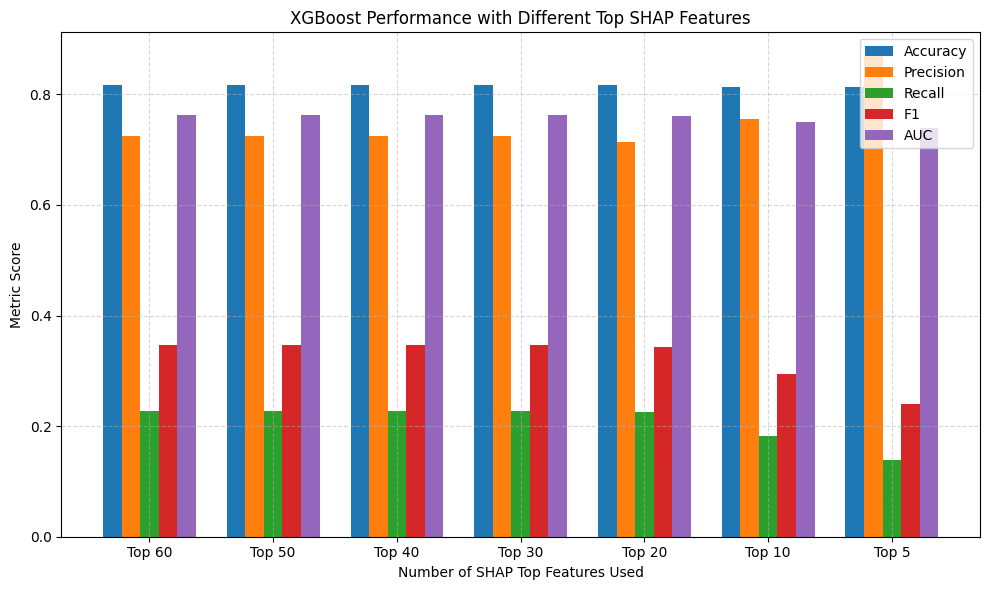

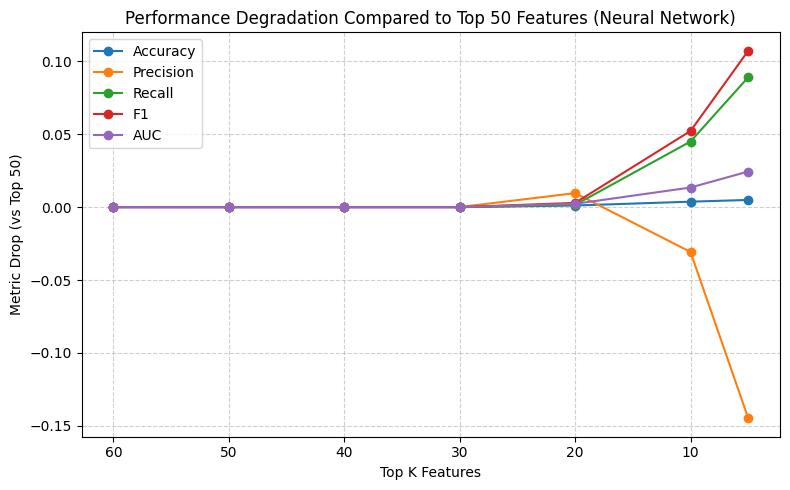

In [9]:
results = []

for k in top_ks:
    result = evaluate_model_with_top_features(
        model_name="Neural Network",
        top_k=k,
        shap_values=shap_values_xgb,  
        X_train_df=X_train_scaled_df,
        X_train_scaled=X_train_scaled,
        X_test_scaled=X_test_scaled,
        y_train=y_train,
        y_test=y_test,
        best_param_map=best_param_map
    )
    results.append(result)


results_df = pd.DataFrame(results)

# visualization
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
x = np.arange(len(top_ks))
bar_width = 0.15

plt.figure(figsize=(10, 6))

for i, metric in enumerate(metrics):
    plt.bar(x + i * bar_width, results_df[metric], width=bar_width, label=metric)

plt.xticks(x + bar_width * 2, [f'Top {k}' for k in top_ks])
plt.ylabel("Metric Score")
plt.xlabel("Number of SHAP Top Features Used")
plt.title("XGBoost Performance with Different Top SHAP Features")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# calculate the degradation of each metric compared to the Top 50 features
baseline = results_df[results_df['Top'] == 50][metrics].values[0]
delta_df = results_df.copy()
for metric in metrics:
    delta_df[metric] = baseline[metrics.index(metric)] - delta_df[metric]

# plot the performance degradation
plt.figure(figsize=(8, 5))
for metric in metrics:
    plt.plot(delta_df['Top'], delta_df[metric], marker='o', label=metric)

plt.xlabel('Top K Features')
plt.ylabel('Metric Drop (vs Top 50)')
plt.title('Performance Degradation Compared to Top 50 Features (Neural Network)')
plt.gca().invert_xaxis() 
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

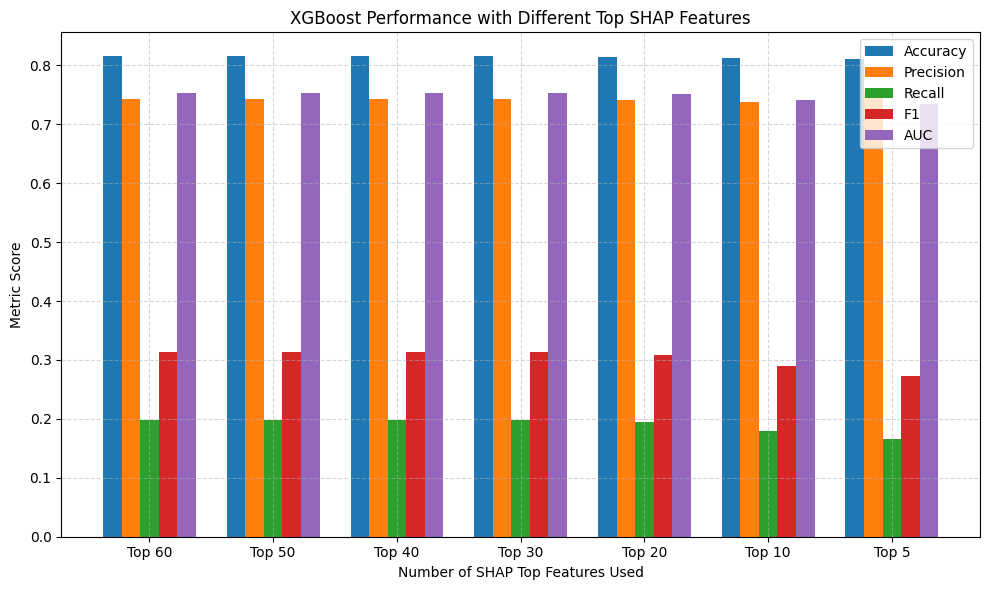

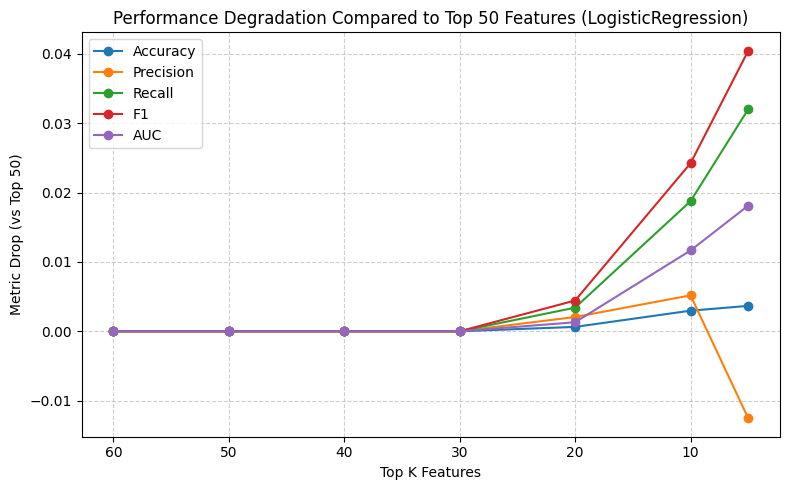

In [11]:
results = []

for k in top_ks:
    result = evaluate_model_with_top_features(
        model_name="LogisticRegression",
        top_k=k,
        shap_values=shap_values_xgb, 
        X_train_df=X_train_scaled_df,
        X_train_scaled=X_train_scaled,
        X_test_scaled=X_test_scaled,
        y_train=y_train,
        y_test=y_test,
        best_param_map=best_param_map
    )
    results.append(result)


results_df = pd.DataFrame(results)

# visualization
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
x = np.arange(len(top_ks))
bar_width = 0.15

plt.figure(figsize=(10, 6))

for i, metric in enumerate(metrics):
    plt.bar(x + i * bar_width, results_df[metric], width=bar_width, label=metric)

plt.xticks(x + bar_width * 2, [f'Top {k}' for k in top_ks])
plt.ylabel("Metric Score")
plt.xlabel("Number of SHAP Top Features Used")
plt.title("XGBoost Performance with Different Top SHAP Features")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# calculate the degradation of each metric compared to the Top 50 features
baseline = results_df[results_df['Top'] == 50][metrics].values[0]
delta_df = results_df.copy()
for metric in metrics:
    delta_df[metric] = baseline[metrics.index(metric)] - delta_df[metric]

# plot the performance degradation
plt.figure(figsize=(8, 5))
for metric in metrics:
    plt.plot(delta_df['Top'], delta_df[metric], marker='o', label=metric)

plt.xlabel('Top K Features')
plt.ylabel('Metric Drop (vs Top 50)')
plt.title('Performance Degradation Compared to Top 50 Features (LogisticRegression)')
plt.gca().invert_xaxis()  
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

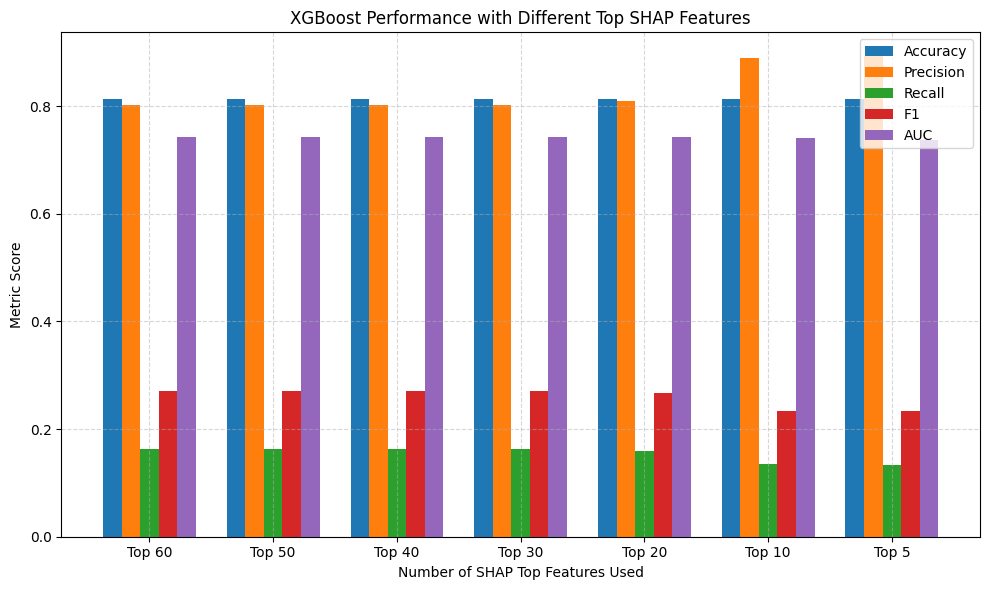

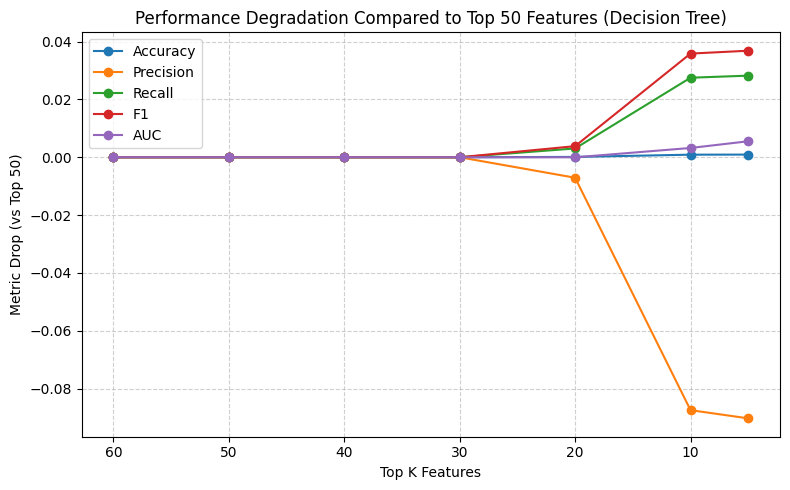

In [12]:
results = []

for k in top_ks:
    result = evaluate_model_with_top_features(
        model_name="Decision Tree",
        top_k=k,
        shap_values=shap_values_xgb,  
        X_train_df=X_train_scaled_df,
        X_train_scaled=X_train_scaled,
        X_test_scaled=X_test_scaled,
        y_train=y_train,
        y_test=y_test,
        best_param_map=best_param_map
    )
    results.append(result)


results_df = pd.DataFrame(results)

# visualization
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
x = np.arange(len(top_ks))
bar_width = 0.15

plt.figure(figsize=(10, 6))

for i, metric in enumerate(metrics):
    plt.bar(x + i * bar_width, results_df[metric], width=bar_width, label=metric)

plt.xticks(x + bar_width * 2, [f'Top {k}' for k in top_ks])
plt.ylabel("Metric Score")
plt.xlabel("Number of SHAP Top Features Used")
plt.title("XGBoost Performance with Different Top SHAP Features")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# calculate the degradation of each metric compared to the Top 50 features
baseline = results_df[results_df['Top'] == 50][metrics].values[0]
delta_df = results_df.copy()
for metric in metrics:
    delta_df[metric] = baseline[metrics.index(metric)] - delta_df[metric]

plt.figure(figsize=(8, 5))
for metric in metrics:
    plt.plot(delta_df['Top'], delta_df[metric], marker='o', label=metric)

plt.xlabel('Top K Features')
plt.ylabel('Metric Drop (vs Top 50)')
plt.title('Performance Degradation Compared to Top 50 Features (Decision Tree)')
plt.gca().invert_xaxis()  
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

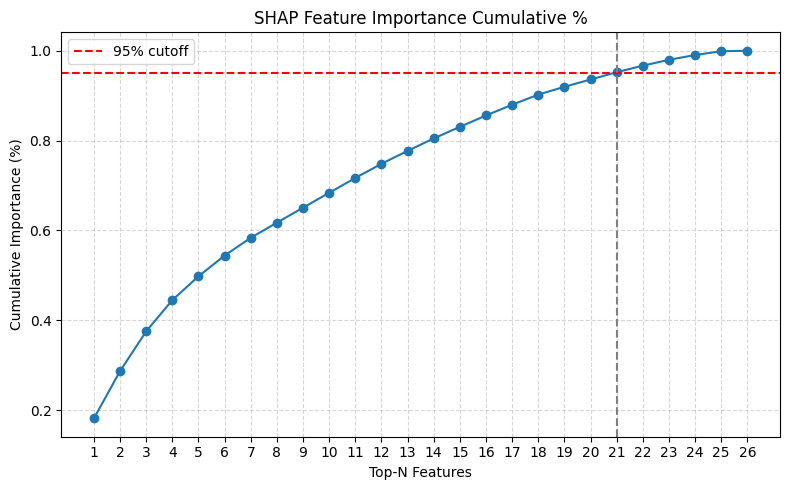

In [13]:
# draw cumulative SHAP feature importance

feature_names = X_test_scaled_df.columns.tolist()
threshold = 0.95

shap_abs_mean = np.abs(shap_values_xgb.values).mean(axis=0)
if feature_names is None:
    feature_names = X_test_scaled.columns if isinstance(X_test_scaled, pd.DataFrame) else [f"X{i}" for i in range(X_test_scaled.shape[1])]

shap_df = pd.DataFrame({
    "feature": feature_names,
    "importance": shap_abs_mean
}).sort_values("importance", ascending=False).reset_index(drop=True)

# calculate cumulative percentage
shap_df["cumsum_pct"] = shap_df["importance"].cumsum() / shap_df["importance"].sum()

# find the cutoff index for the specified threshold
cutoff_idx = (shap_df["cumsum_pct"] >= threshold).idxmax()
top_features = shap_df.loc[:cutoff_idx, "feature"].tolist()

# plot
plt.figure(figsize=(8,5))
plt.plot(np.arange(1, len(shap_df)+1), shap_df["cumsum_pct"], marker='o')
plt.axhline(threshold, color='r', linestyle='--', label=f"{threshold*100:.0f}% cutoff")
plt.axvline(cutoff_idx+1, color='gray', linestyle='--')
plt.title("SHAP Feature Importance Cumulative %")
plt.xlabel("Top-N Features")
plt.ylabel("Cumulative Importance (%)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(np.arange(1, len(shap_df)+1, step=max(1, len(shap_df)//20)))
plt.tight_layout()
plt.legend()
plt.show()

